# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
# !pip install --upgrade pandas numpy matplotlib scipy
!pip install -U scikit-learn

In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib as mp
import time
import scipy.stats as st
import lightgbm as lgb
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance

from sklearn.dummy import DummyRegressor,DummyClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.tree import plot_tree, _tree
from sklearn.svm import SVC
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.compose import make_column_transformer



from sklearn.metrics import (r2_score,
                             mean_absolute_error,
                             mean_squared_error,
                             precision_score,
                             recall_score,
                             accuracy_score,
                             f1_score,
                             fbeta_score,
                             roc_curve,
                             roc_auc_score,
                             RocCurveDisplay,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             make_scorer,
                             root_mean_squared_error
                            )


from sklearn.model_selection import (train_test_split,
                                     GridSearchCV,
                                     RandomizedSearchCV,
                                     cross_val_score
                                    )

from sklearn.preprocessing import (StandardScaler,
                                   MinMaxScaler,
                                   RobustScaler,
                                   OneHotEncoder,
                                   LabelEncoder,
                                   OrdinalEncoder
                                  )


RANDOM_STATE = 42
TEST_SIZE = 0.25
# SEED = 31610

sb.set(style = 'whitegrid')
sb.set(rc={'figure.figsize':(16,9)})
sb.set_context('paper', rc={'font.size': 10,
                             'axes.titlesize': 10,
                             'xtrick.labelsize': 'small',
                             'ytrick.labelsize': 'small',
                             'legend.fontsize': 'small',
                             'legend.title_fontsize':10})


### Загрузка и изучение данных

In [3]:
data = pd.read_csv('/datasets/autos.csv')

In [4]:
display(data.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Text(0.5, 1.0, 'Карта пропусков')

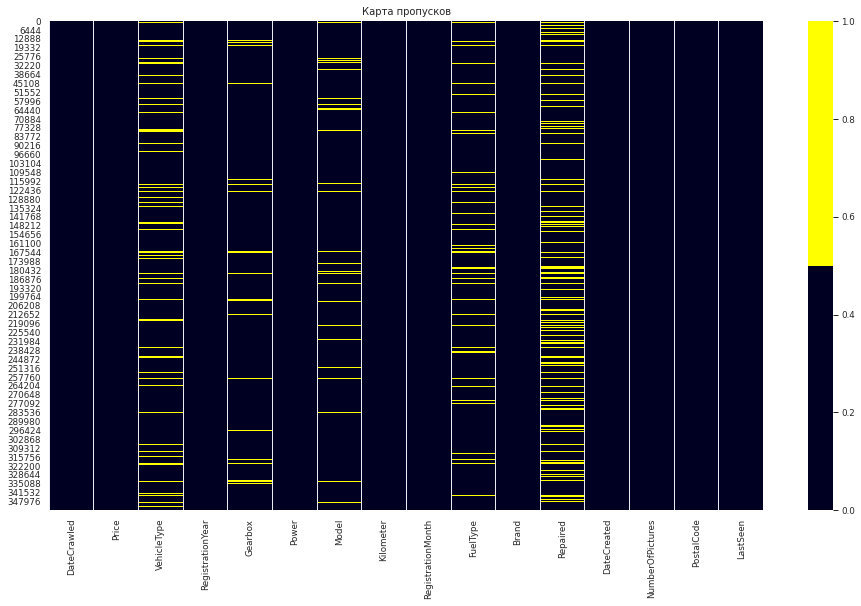

In [6]:
colours = ['#0026', '#ffff00'] 
table = sb.heatmap(data.isnull(), cmap=sb.color_palette(colours))
table.set_title('Карта пропусков')

### Пердобработка

#### Обработка пропусков

In [7]:
print(data.isna().sum(),'\n\n')
print('% Пропусков в датасете','\n\n',round(data.isna().sum()*100/len(data),1))

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64 


% Пропусков в датасете 

 DateCrawled           0.0
Price                 0.0
VehicleType          10.6
RegistrationYear      0.0
Gearbox               5.6
Power                 0.0
Model                 5.6
Kilometer             0.0
RegistrationMonth     0.0
FuelType              9.3
Brand                 0.0
Repaired             20.1
DateCreated           0.0
NumberOfPictures      0.0
PostalCode            0.0
LastSeen              0.0
dtype: float64


In [8]:
for i in data.columns:
    if data[i].dtype == 'object': 
        print(i)
        print(data[i].unique())

DateCrawled
['2016-03-24 11:52:17' '2016-03-24 10:58:45' '2016-03-14 12:52:21' ...
 '2016-03-21 09:50:58' '2016-03-14 17:48:27' '2016-03-19 18:57:12']
VehicleType
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Gearbox
['manual' 'auto' nan]
Model
['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 

По параметру Repaired наблюдается более 20% пропусков в значениях, информацию такого качества нельзя передавать модели. Параметр будет удален. Полных дубликатов не обнаружено. Пропуски в типе автомабильного кузова заменим на значение "other". Параметры: Gearbox, Model и FuelType заполним модой.

In [9]:
data = data.drop('Repaired',axis=1)
data['VehicleType'] = data['VehicleType'].fillna('other')
data['Gearbox'] = data['Gearbox'].fillna('manual')
data['Model'] = data['Model'].fillna('golf')
data['FuelType'] = data['FuelType'].fillna('petrol')

#### Обработка аномалий

Price


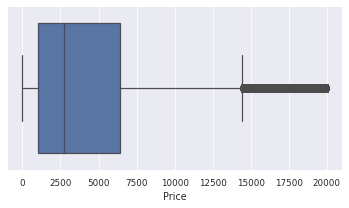

RegistrationYear


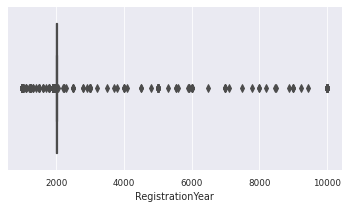

Power


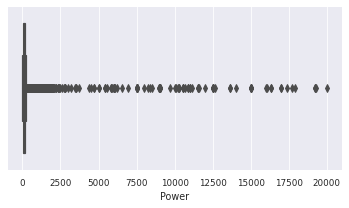

Kilometer


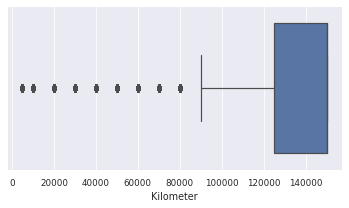

RegistrationMonth


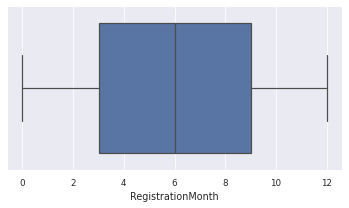

NumberOfPictures


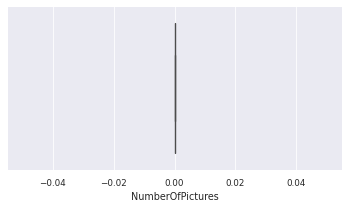

PostalCode


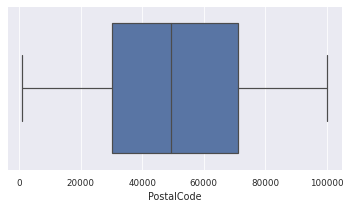

In [10]:
for col in data.columns: 
    if data[col].dtype in ['int64', 'float64']:
        print(col)
        plt.figure(figsize=(6,3)) 
        sb.boxplot(x=data[col]) 
        plt.show() 

In [11]:
data.loc[data['RegistrationYear'] > 2024, 'RegistrationYear'] = 2003
data.loc[data['RegistrationYear'] < 2016, 'RegistrationYear'] = 2003
data.loc[data['Power'] > 1000, 'Power'] = 105

In [12]:
data.dropna(subset=['Price'], inplace=True)
data = data.loc[data['Price'] > 10]
data = data.loc[data['Power'] != 0]

In [13]:
data = data.drop(['DateCreated','NumberOfPictures','PostalCode','LastSeen'],axis=1)

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Age'>

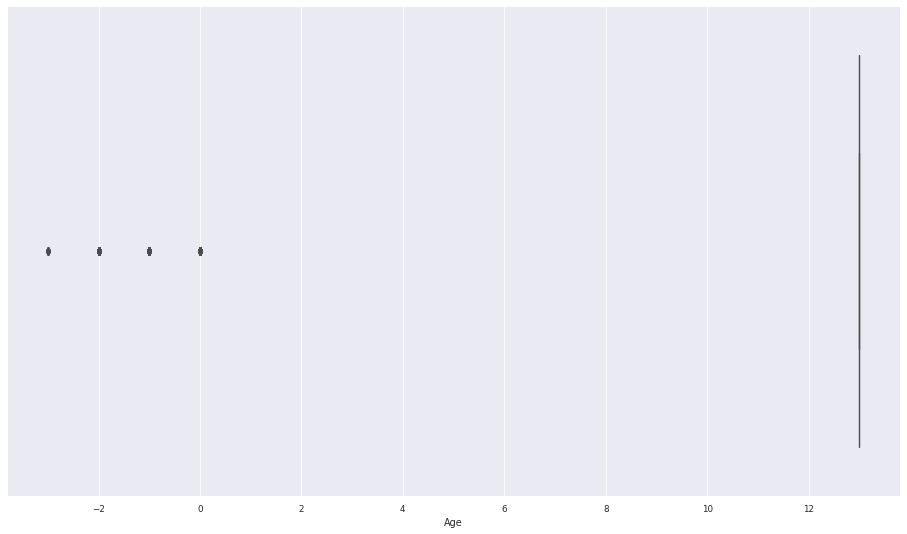

In [14]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'])
data['DateCrawled'] = pd.DatetimeIndex(data['DateCrawled']).year

data['Age'] = data['DateCrawled'] - data['RegistrationYear']
data = data.drop('DateCrawled', axis=1)
sb.boxplot(data['Age'])

- По параметру Repaired наблюдалось более 20% пропусков в значениях, параметр был удален
- Полных дубликатов не обнаружено
- Пропуски в типе автомабильного кузова заменили на значение "other"
- Параметры: Gearbox, Model и FuelType заполнили модой
- Аномалии в годе регистрации и мощности заполнили медианными значениями
- Параметры: почтовый индекс, дата скачивания анкеты, дата создания анкеты, количество фотографий авт., дата последней активности были удалены, так как цена на автомобиль от них не зависит.

### Корреляционный анализ данных

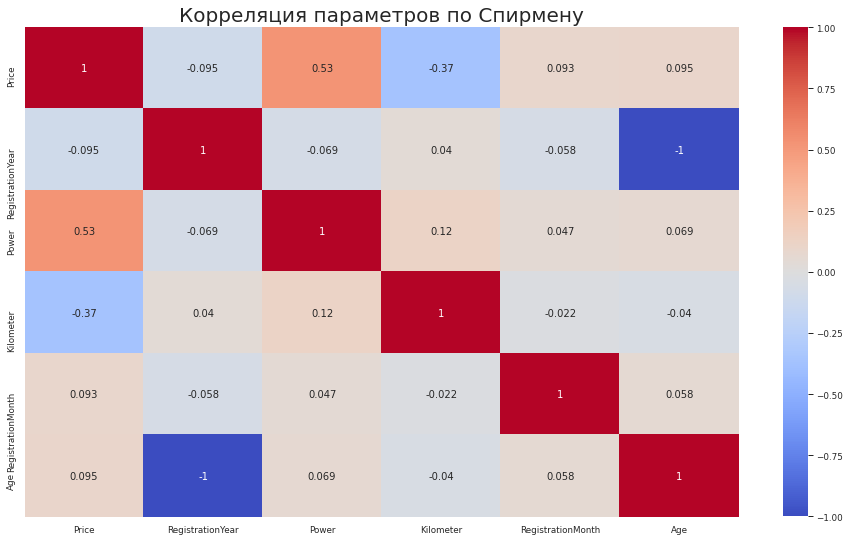

In [15]:
data_corr = sb.heatmap(data.corr(method = 'spearman'), annot=True, cmap='coolwarm')
data_corr.set_title('Корреляция параметров по Спирмену', fontsize=20)
plt.show()

## Обучение моделей

In [16]:
X = data.drop('Price', axis=1)
y = data['Price']
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
)

In [17]:
ohe_features_ridge = X_train.select_dtypes(include='object').columns.to_list()
num_features =  X_train.select_dtypes(exclude='object').columns.to_list()

In [18]:
ohe_pipe = Pipeline(
    [
        ('ohe', OneHotEncoder(drop='first',sparse_output=False,handle_unknown='ignore'))
    ])

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_features_ridge),
        ('num', MinMaxScaler(), num_features)
    ],
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])


In [19]:
param_grid = [
    {
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__ohe': [ohe_pipe],
        'models': [LinearRegression()]
    }
]

In [20]:
def model_analysis(model, parameters, features_train, target_train):
    
    # задаем кросвал цикл
    random = RandomizedSearchCV(
        model, 
        parameters, 
        cv=5,
        random_state=RANDOM_STATE,
        scoring = 'neg_root_mean_squared_error'
    )
    
    # учимся
    random.fit(features_train,target_train)
#     rmse = 0
#     first_time = 0
#     second_time = 0
    
    # замеряем время обучения лучшей модели
    start_time = time.time()
    random.best_estimator_.fit(features_train,target_train)
    first_time = time.time() - start_time
    
    # замеряем время предсказания лучшей модели
    start_time = time.time()
    predict = random.best_estimator_.predict(features_train)
    second_time = time.time() - start_time
    
    # сохраняем метрику лучщей модели
    rmse = random.best_score_

    
    # возвращаем каскад из времени и оценки
    stat_data = [first_time, second_time, rmse]
    return stat_data, random



In [21]:
des_stat, des_grid = model_analysis(pipe_final, param_grid,
                                      X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknow

### LGBM

In [22]:
def model_analysis_2(model, parameters, features_train, target_train):
    start_time = time.time()
    random = RandomizedSearchCV(
        model, 
        parameters, 
        cv=5, 
        n_jobs=-1,
        error_score='raise',
        random_state=RANDOM_STATE,
        scoring = 'neg_root_mean_squared_error'
    )
    random.fit(features_train,target_train)
    random.best_estimator_.fit(features_train,target_train)
    first_time = time.time() - start_time
    start_time = time.time()
    
    predict = random.best_estimator_.predict(features_train)
    second_time = time.time() - start_time
    
    rmse = np.sqrt(mean_squared_error(target_train, predict))
    stat_data = [first_time, second_time, rmse]
    return stat_data, random

In [23]:
features_train_ridge = X_train.copy()

category = ['VehicleType', 'Gearbox', 'Model', 'FuelType','Brand']
# # Ordinal Encoding
# OE_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=(-1)) # UPD
# OE_encoder.fit(X_train[category])

for category in features_train_ridge:
    features_train_ridge[category] = features_train_ridge[category].astype('category')
    
features_train_ridge['RegistrationYear'] = features_train_ridge['RegistrationYear'].astype('int32')
features_train_ridge['Kilometer'] = features_train_ridge['Kilometer'].astype('int32')
features_train_ridge['Power'] = features_train_ridge['Power'].astype('int32')
features_train_ridge['RegistrationMonth'] = features_train_ridge['RegistrationMonth'].astype('int32')
features_train_ridge['Age'] = features_train_ridge['Age'].astype('int32')

lgbm_model = LGBMRegressor(random_state=RANDOM_STATE)

param_lgbm = {
    'n_estimators': [50, 100, 150],
    'max_depth': [8, 16, 24],
    'num_leaves': [8, 16, 32],
    'learning_rate': [0.1]
}

In [24]:
     lgbm_stat, lgbm_grid = model_analysis_2(lgbm_model, param_lgbm,
                                       features_train_ridge, y_train)

### CatBoost

In [25]:
for category in features_train_ridge:
    features_train_ridge[category] = features_train_ridge[category].astype('object')
    
features_train_ridge['RegistrationYear'] = features_train_ridge['RegistrationYear'].astype('int32')
features_train_ridge['Kilometer'] = features_train_ridge['Kilometer'].astype('int32')
features_train_ridge['Power'] = features_train_ridge['Power'].astype('int32')
features_train_ridge['RegistrationMonth'] = features_train_ridge['RegistrationMonth'].astype('int32')
features_train_ridge['Age'] = features_train_ridge['Age'].astype('int32')

In [26]:
def model_analysis_3(model, parameters, features_train, target_train):
    start_time = time.time()
    random = RandomizedSearchCV(
        model, 
        parameters, 
        cv=5, 
        n_jobs=-1,
        error_score='raise',
        random_state=RANDOM_STATE,
        scoring = 'neg_root_mean_squared_error'
    )
    categorical_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType','Brand']
    random.fit(features_train,target_train,cat_features=categorical_features, plot=True)
    random.best_estimator_.fit(features_train,target_train,cat_features=categorical_features, plot=True)
    first_time = time.time() - start_time
    start_time = time.time()
    
    predict = random.best_estimator_.predict(features_train)
    second_time = time.time() - start_time
    
    rmse = np.sqrt(mean_squared_error(target_train, predict))
    stat_data = [first_time, second_time, rmse]
    return stat_data, random

catboost_model = CatBoostRegressor()

params_catboost = {
    'learning_rate': [0.1],
    'iterations': [8,35,95],
    'max_depth': [11,16]
}

In [27]:
catboost_stat, catboost_grid = model_analysis_3(catboost_model, params_catboost,
                                              features_train_ridge, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4316.6589591	total: 194ms	remaining: 1.36s
1:	learn: 4087.3465208	total: 366ms	remaining: 1.1s
2:	learn: 3892.3559904	total: 479ms	remaining: 799ms
3:	learn: 3722.5945434	total: 611ms	remaining: 611ms
4:	learn: 3578.8575770	total: 717ms	remaining: 430ms
5:	learn: 3451.0232108	total: 830ms	remaining: 277ms
6:	learn: 3343.0843089	total: 940ms	remaining: 134ms
7:	learn: 3254.5548094	total: 1.05s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4318.1119196	total: 123ms	remaining: 859ms
1:	learn: 4092.0968216	total: 241ms	remaining: 724ms
2:	learn: 3896.6802774	total: 349ms	remaining: 581ms
3:	learn: 3725.2478889	total: 472ms	remaining: 472ms
4:	learn: 3581.0173901	total: 582ms	remaining: 349ms
5:	learn: 3459.2945016	total: 695ms	remaining: 232ms
6:	learn: 3349.0010151	total: 814ms	remaining: 116ms
7:	learn: 3259.3831916	total: 925ms	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4323.6449646	total: 122ms	remaining: 852ms
1:	learn: 4100.8776844	total: 237ms	remaining: 711ms
2:	learn: 3906.1962220	total: 339ms	remaining: 565ms
3:	learn: 3729.6815776	total: 458ms	remaining: 458ms
4:	learn: 3578.6534157	total: 569ms	remaining: 342ms
5:	learn: 3452.5820099	total: 689ms	remaining: 230ms
6:	learn: 3345.0820519	total: 802ms	remaining: 115ms
7:	learn: 3253.2139545	total: 915ms	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4315.5407703	total: 121ms	remaining: 845ms
1:	learn: 4086.3812477	total: 239ms	remaining: 716ms
2:	learn: 3892.6602116	total: 350ms	remaining: 584ms
3:	learn: 3725.4548602	total: 477ms	remaining: 477ms
4:	learn: 3579.3484052	total: 591ms	remaining: 355ms
5:	learn: 3457.4484649	total: 710ms	remaining: 237ms
6:	learn: 3348.9139480	total: 836ms	remaining: 119ms
7:	learn: 3257.2692146	total: 962ms	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4317.2607780	total: 129ms	remaining: 905ms
1:	learn: 4088.4939634	total: 255ms	remaining: 765ms
2:	learn: 3892.5525849	total: 369ms	remaining: 615ms
3:	learn: 3722.7795242	total: 504ms	remaining: 504ms
4:	learn: 3576.3732106	total: 626ms	remaining: 376ms
5:	learn: 3449.6393443	total: 761ms	remaining: 254ms
6:	learn: 3340.3547429	total: 886ms	remaining: 127ms
7:	learn: 3250.4154582	total: 997ms	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4312.2809710	total: 1.26s	remaining: 8.85s
1:	learn: 4081.6655534	total: 2.25s	remaining: 6.74s
2:	learn: 3880.1779817	total: 3.32s	remaining: 5.54s
3:	learn: 3700.4061435	total: 4.39s	remaining: 4.39s
4:	learn: 3551.0904715	total: 5.35s	remaining: 3.21s
5:	learn: 3422.9886853	total: 6.4s	remaining: 2.13s
6:	learn: 3315.5359949	total: 7.48s	remaining: 1.07s
7:	learn: 3226.4008734	total: 7.76s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4316.3133565	total: 208ms	remaining: 1.46s
1:	learn: 4081.4852842	total: 1.24s	remaining: 3.71s
2:	learn: 3883.4944429	total: 1.39s	remaining: 2.31s
3:	learn: 3705.0464100	total: 2.45s	remaining: 2.45s
4:	learn: 3553.4386497	total: 3.5s	remaining: 2.1s
5:	learn: 3424.6117714	total: 4.54s	remaining: 1.51s
6:	learn: 3313.8397231	total: 5.61s	remaining: 801ms
7:	learn: 3221.1897849	total: 6.66s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4319.3265251	total: 1.02s	remaining: 7.14s
1:	learn: 4090.2965687	total: 1.55s	remaining: 4.65s
2:	learn: 3891.6248436	total: 2.62s	remaining: 4.36s
3:	learn: 3713.3337382	total: 3.71s	remaining: 3.71s
4:	learn: 3559.6724170	total: 4.78s	remaining: 2.87s
5:	learn: 3431.7956451	total: 5.28s	remaining: 1.76s
6:	learn: 3318.6546509	total: 6.32s	remaining: 902ms
7:	learn: 3222.6677888	total: 7.35s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4308.3603027	total: 1.02s	remaining: 7.17s
1:	learn: 4079.6114020	total: 1.55s	remaining: 4.65s
2:	learn: 3881.2945329	total: 2.58s	remaining: 4.3s
3:	learn: 3705.2475040	total: 3.68s	remaining: 3.68s
4:	learn: 3553.5328790	total: 4.74s	remaining: 2.85s
5:	learn: 3427.9039576	total: 5.78s	remaining: 1.93s
6:	learn: 3320.0874293	total: 6.83s	remaining: 975ms
7:	learn: 3225.3350351	total: 7.85s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4308.6228325	total: 1.07s	remaining: 7.51s
1:	learn: 4079.9084484	total: 1.57s	remaining: 4.71s
2:	learn: 3880.3805466	total: 2.64s	remaining: 4.4s
3:	learn: 3701.5287792	total: 3.67s	remaining: 3.67s
4:	learn: 3546.8343348	total: 4.75s	remaining: 2.85s
5:	learn: 3419.0153554	total: 5.8s	remaining: 1.93s
6:	learn: 3310.5252854	total: 6.84s	remaining: 977ms
7:	learn: 3214.9598870	total: 7.88s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4316.6589591	total: 143ms	remaining: 4.86s
1:	learn: 4087.3465208	total: 267ms	remaining: 4.4s
2:	learn: 3892.3559904	total: 383ms	remaining: 4.08s
3:	learn: 3722.5945434	total: 507ms	remaining: 3.93s
4:	learn: 3578.8575770	total: 621ms	remaining: 3.73s
5:	learn: 3451.0232108	total: 739ms	remaining: 3.57s
6:	learn: 3343.0843089	total: 852ms	remaining: 3.41s
7:	learn: 3254.5548094	total: 983ms	remaining: 3.32s
8:	learn: 3178.6561537	total: 1.09s	remaining: 3.16s
9:	learn: 3113.5650592	total: 1.22s	remaining: 3.04s
10:	learn: 3047.9873071	total: 1.33s	remaining: 2.9s
11:	learn: 2990.6472887	total: 1.44s	remaining: 2.76s
12:	learn: 2932.2765680	total: 1.56s	remaining: 2.64s
13:	learn: 2883.0479158	total: 1.69s	remaining: 2.53s
14:	learn: 2841.2874638	total: 1.83s	remaining: 2.44s
15:	learn: 2807.4934809	total: 1.94s	remaining: 2.31s
16:	learn: 2778.5241548	total: 2.05s	remaining: 2.17s
17:	learn: 2751.4326340	total: 2.16s	remaining: 2.04s
18:	learn: 2729.4277864	total: 2.27s	rem

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4318.1119196	total: 128ms	remaining: 4.35s
1:	learn: 4092.0968216	total: 251ms	remaining: 4.13s
2:	learn: 3896.6802774	total: 359ms	remaining: 3.83s
3:	learn: 3725.2478889	total: 492ms	remaining: 3.81s
4:	learn: 3581.0173901	total: 606ms	remaining: 3.64s
5:	learn: 3459.2945016	total: 729ms	remaining: 3.52s
6:	learn: 3349.0010151	total: 847ms	remaining: 3.39s
7:	learn: 3259.3831916	total: 963ms	remaining: 3.25s
8:	learn: 3182.5561234	total: 1.08s	remaining: 3.13s
9:	learn: 3114.9434045	total: 1.2s	remaining: 3s
10:	learn: 3047.6885637	total: 1.32s	remaining: 2.89s
11:	learn: 2989.9251143	total: 1.44s	remaining: 2.76s
12:	learn: 2929.3245869	total: 1.58s	remaining: 2.68s
13:	learn: 2880.4485138	total: 1.7s	remaining: 2.55s
14:	learn: 2837.6040508	total: 1.84s	remaining: 2.45s
15:	learn: 2801.7467919	total: 1.96s	remaining: 2.33s
16:	learn: 2770.8980974	total: 2.07s	remaining: 2.19s
17:	learn: 2744.6157257	total: 2.18s	remaining: 2.06s
18:	learn: 2720.3555906	total: 2.29s	remain

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4323.6449646	total: 123ms	remaining: 4.17s
1:	learn: 4100.8776844	total: 242ms	remaining: 3.99s
2:	learn: 3906.1962220	total: 350ms	remaining: 3.73s
3:	learn: 3729.6815776	total: 472ms	remaining: 3.65s
4:	learn: 3578.6534157	total: 584ms	remaining: 3.5s
5:	learn: 3452.5820099	total: 695ms	remaining: 3.36s
6:	learn: 3345.0820519	total: 808ms	remaining: 3.23s
7:	learn: 3253.2139545	total: 923ms	remaining: 3.11s
8:	learn: 3174.9480351	total: 1.03s	remaining: 2.99s
9:	learn: 3098.5114405	total: 1.15s	remaining: 2.88s
10:	learn: 3034.8733356	total: 1.28s	remaining: 2.8s
11:	learn: 2981.0527879	total: 1.4s	remaining: 2.68s
12:	learn: 2922.9072435	total: 1.51s	remaining: 2.56s
13:	learn: 2873.5212899	total: 1.63s	remaining: 2.45s
14:	learn: 2832.0209570	total: 1.74s	remaining: 2.32s
15:	learn: 2798.8756394	total: 1.85s	remaining: 2.2s
16:	learn: 2769.2398996	total: 1.97s	remaining: 2.08s
17:	learn: 2743.1903087	total: 2.08s	remaining: 1.96s
18:	learn: 2720.4669204	total: 2.19s	remai

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4315.5407703	total: 126ms	remaining: 4.29s
1:	learn: 4086.3812477	total: 253ms	remaining: 4.18s
2:	learn: 3892.6602116	total: 472ms	remaining: 5.03s
3:	learn: 3725.4548602	total: 625ms	remaining: 4.84s
4:	learn: 3579.3484052	total: 746ms	remaining: 4.48s
5:	learn: 3457.4484649	total: 863ms	remaining: 4.17s
6:	learn: 3348.9139480	total: 1.08s	remaining: 4.33s
7:	learn: 3257.2692146	total: 1.23s	remaining: 4.15s
8:	learn: 3182.0953150	total: 1.34s	remaining: 3.86s
9:	learn: 3104.2401859	total: 1.46s	remaining: 3.65s
10:	learn: 3040.3035981	total: 1.58s	remaining: 3.45s
11:	learn: 2983.5308374	total: 1.69s	remaining: 3.25s
12:	learn: 2925.1853315	total: 1.81s	remaining: 3.06s
13:	learn: 2875.8772995	total: 1.92s	remaining: 2.88s
14:	learn: 2833.9780745	total: 2.03s	remaining: 2.71s
15:	learn: 2798.3024161	total: 2.17s	remaining: 2.58s
16:	learn: 2767.1966121	total: 2.28s	remaining: 2.42s
17:	learn: 2741.5597314	total: 2.4s	remaining: 2.27s
18:	learn: 2719.8701293	total: 2.52s	re

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4317.2607780	total: 128ms	remaining: 4.34s
1:	learn: 4088.4939634	total: 249ms	remaining: 4.12s
2:	learn: 3892.5525849	total: 359ms	remaining: 3.83s
3:	learn: 3722.7795242	total: 483ms	remaining: 3.74s
4:	learn: 3576.3732106	total: 608ms	remaining: 3.65s
5:	learn: 3449.6393443	total: 717ms	remaining: 3.46s
6:	learn: 3340.3547429	total: 828ms	remaining: 3.31s
7:	learn: 3250.4154582	total: 942ms	remaining: 3.18s
8:	learn: 3173.1096668	total: 1.05s	remaining: 3.04s
9:	learn: 3097.9312862	total: 1.17s	remaining: 2.93s
10:	learn: 3032.4647245	total: 1.28s	remaining: 2.8s
11:	learn: 2978.4620194	total: 1.39s	remaining: 2.66s
12:	learn: 2921.9912582	total: 1.51s	remaining: 2.55s
13:	learn: 2873.0847569	total: 1.62s	remaining: 2.43s
14:	learn: 2830.7514111	total: 1.74s	remaining: 2.32s
15:	learn: 2796.6462350	total: 1.85s	remaining: 2.2s
16:	learn: 2766.5122572	total: 1.98s	remaining: 2.09s
17:	learn: 2740.7238645	total: 2.1s	remaining: 1.98s
18:	learn: 2719.1522680	total: 2.23s	rema

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4312.2809710	total: 1.06s	remaining: 36.2s
1:	learn: 4081.6655534	total: 2s	remaining: 32.9s
2:	learn: 3880.1779817	total: 3.06s	remaining: 32.7s
3:	learn: 3700.4061435	total: 4.17s	remaining: 32.3s
4:	learn: 3551.0904715	total: 5.07s	remaining: 30.4s
5:	learn: 3422.9886853	total: 6.15s	remaining: 29.7s
6:	learn: 3315.5359949	total: 7.24s	remaining: 29s
7:	learn: 3226.4008734	total: 7.52s	remaining: 25.4s
8:	learn: 3143.5823572	total: 8.58s	remaining: 24.8s
9:	learn: 3061.4310410	total: 9.63s	remaining: 24.1s
10:	learn: 2993.2667959	total: 10.7s	remaining: 23.3s
11:	learn: 2935.2462709	total: 11.7s	remaining: 22.5s
12:	learn: 2884.9252239	total: 12.8s	remaining: 21.7s
13:	learn: 2829.4598388	total: 13.9s	remaining: 20.8s
14:	learn: 2779.4397635	total: 14.9s	remaining: 19.9s
15:	learn: 2736.3015257	total: 16s	remaining: 19s
16:	learn: 2699.2017355	total: 17s	remaining: 18s
17:	learn: 2668.6126399	total: 18.1s	remaining: 17.1s
18:	learn: 2638.4897312	total: 19.1s	remaining: 16.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4316.3133565	total: 188ms	remaining: 6.39s
1:	learn: 4081.4852842	total: 1.21s	remaining: 20s
2:	learn: 3883.4944429	total: 1.34s	remaining: 14.3s
3:	learn: 3705.0464100	total: 2.39s	remaining: 18.5s
4:	learn: 3553.4386497	total: 3.41s	remaining: 20.5s
5:	learn: 3424.6117714	total: 4.42s	remaining: 21.4s
6:	learn: 3313.8397231	total: 5.42s	remaining: 21.7s
7:	learn: 3221.1897849	total: 6.42s	remaining: 21.7s
8:	learn: 3143.4556322	total: 7.47s	remaining: 21.6s
9:	learn: 3063.8734162	total: 8.5s	remaining: 21.3s
10:	learn: 2994.4247915	total: 9.53s	remaining: 20.8s
11:	learn: 2933.6506595	total: 10.6s	remaining: 20.3s
12:	learn: 2869.9599743	total: 11.6s	remaining: 19.6s
13:	learn: 2812.0591334	total: 12.6s	remaining: 19s
14:	learn: 2762.2687753	total: 13.7s	remaining: 18.3s
15:	learn: 2719.2832830	total: 14.7s	remaining: 17.5s
16:	learn: 2682.1623440	total: 15.8s	remaining: 16.7s
17:	learn: 2650.3024857	total: 16.8s	remaining: 15.9s
18:	learn: 2620.8776033	total: 17.8s	remain

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4319.3265251	total: 1.03s	remaining: 35.2s
1:	learn: 4090.2965687	total: 1.5s	remaining: 24.8s
2:	learn: 3891.6248436	total: 2.54s	remaining: 27.1s
3:	learn: 3713.3337382	total: 3.55s	remaining: 27.5s
4:	learn: 3559.6724170	total: 4.58s	remaining: 27.5s
5:	learn: 3431.7956451	total: 5.07s	remaining: 24.5s
6:	learn: 3318.6546509	total: 6.08s	remaining: 24.3s
7:	learn: 3222.6677888	total: 7.11s	remaining: 24s
8:	learn: 3140.2344919	total: 8.13s	remaining: 23.5s
9:	learn: 3058.8582268	total: 9.19s	remaining: 23s
10:	learn: 2987.0036200	total: 10.2s	remaining: 22.2s
11:	learn: 2928.3062760	total: 11.2s	remaining: 21.5s
12:	learn: 2877.8198313	total: 12.2s	remaining: 20.7s
13:	learn: 2819.8946354	total: 13.3s	remaining: 19.9s
14:	learn: 2768.2238303	total: 14.3s	remaining: 19s
15:	learn: 2724.2274998	total: 15.3s	remaining: 18.2s
16:	learn: 2687.2094143	total: 16.3s	remaining: 17.3s
17:	learn: 2654.8640524	total: 17.4s	remaining: 16.4s
18:	learn: 2626.1228014	total: 18.4s	remainin

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4308.3603027	total: 1.15s	remaining: 39s
1:	learn: 4079.6114020	total: 1.65s	remaining: 27.2s
2:	learn: 3881.2945329	total: 2.69s	remaining: 28.7s
3:	learn: 3705.2475040	total: 3.75s	remaining: 29.1s
4:	learn: 3553.5328790	total: 4.78s	remaining: 28.7s
5:	learn: 3427.9039576	total: 5.81s	remaining: 28.1s
6:	learn: 3320.0874293	total: 6.85s	remaining: 27.4s
7:	learn: 3225.3350351	total: 7.88s	remaining: 26.6s
8:	learn: 3130.0678934	total: 8.95s	remaining: 25.9s
9:	learn: 3049.2386274	total: 9.99s	remaining: 25s
10:	learn: 2981.3482217	total: 11s	remaining: 24.1s
11:	learn: 2923.8474622	total: 12.1s	remaining: 23.1s
12:	learn: 2871.6274540	total: 13.1s	remaining: 22.2s
13:	learn: 2814.7776031	total: 14.2s	remaining: 21.2s
14:	learn: 2765.5798192	total: 15.2s	remaining: 20.3s
15:	learn: 2720.1752776	total: 16.2s	remaining: 19.3s
16:	learn: 2679.7334614	total: 17.3s	remaining: 18.3s
17:	learn: 2645.4755669	total: 18.3s	remaining: 17.3s
18:	learn: 2617.8017056	total: 19.3s	remaini

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4308.6228325	total: 1.04s	remaining: 35.4s
1:	learn: 4079.9084484	total: 1.55s	remaining: 25.6s
2:	learn: 3880.3805466	total: 2.59s	remaining: 27.6s
3:	learn: 3701.5287792	total: 3.61s	remaining: 28s
4:	learn: 3546.8343348	total: 4.64s	remaining: 27.9s
5:	learn: 3419.0153554	total: 5.68s	remaining: 27.5s
6:	learn: 3310.5252854	total: 6.69s	remaining: 26.7s
7:	learn: 3214.9598870	total: 7.71s	remaining: 26s
8:	learn: 3122.5520357	total: 8.75s	remaining: 25.3s
9:	learn: 3041.6424601	total: 9.78s	remaining: 24.4s
10:	learn: 2974.2405602	total: 10.9s	remaining: 23.7s
11:	learn: 2915.8435995	total: 11.9s	remaining: 22.9s
12:	learn: 2864.5855678	total: 13s	remaining: 21.9s
13:	learn: 2805.7188424	total: 14s	remaining: 21.1s
14:	learn: 2756.4787503	total: 15.1s	remaining: 20.1s
15:	learn: 2715.0090389	total: 16.1s	remaining: 19.1s
16:	learn: 2678.4127893	total: 17.1s	remaining: 18.2s
17:	learn: 2646.5997290	total: 18.2s	remaining: 17.2s
18:	learn: 2616.6213962	total: 19.2s	remaining

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4316.6589591	total: 113ms	remaining: 10.7s
1:	learn: 4087.3465208	total: 220ms	remaining: 10.2s
2:	learn: 3892.3559904	total: 331ms	remaining: 10.1s
3:	learn: 3722.5945434	total: 453ms	remaining: 10.3s
4:	learn: 3578.8575770	total: 582ms	remaining: 10.5s
5:	learn: 3451.0232108	total: 696ms	remaining: 10.3s
6:	learn: 3343.0843089	total: 809ms	remaining: 10.2s
7:	learn: 3254.5548094	total: 913ms	remaining: 9.92s
8:	learn: 3178.6561537	total: 1.03s	remaining: 9.83s
9:	learn: 3113.5650592	total: 1.13s	remaining: 9.63s
10:	learn: 3047.9873071	total: 1.24s	remaining: 9.47s
11:	learn: 2990.6472887	total: 1.34s	remaining: 9.3s
12:	learn: 2932.2765680	total: 1.45s	remaining: 9.15s
13:	learn: 2883.0479158	total: 1.55s	remaining: 8.99s
14:	learn: 2841.2874638	total: 1.66s	remaining: 8.86s
15:	learn: 2807.4934809	total: 1.77s	remaining: 8.73s
16:	learn: 2778.5241548	total: 1.87s	remaining: 8.6s
17:	learn: 2751.4326340	total: 1.98s	remaining: 8.47s
18:	learn: 2729.4277864	total: 2.1s	rema

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4318.1119196	total: 114ms	remaining: 10.8s
1:	learn: 4092.0968216	total: 228ms	remaining: 10.6s
2:	learn: 3896.6802774	total: 330ms	remaining: 10.1s
3:	learn: 3725.2478889	total: 448ms	remaining: 10.2s
4:	learn: 3581.0173901	total: 555ms	remaining: 9.99s
5:	learn: 3459.2945016	total: 663ms	remaining: 9.84s
6:	learn: 3349.0010151	total: 774ms	remaining: 9.73s
7:	learn: 3259.3831916	total: 880ms	remaining: 9.57s
8:	learn: 3182.5561234	total: 988ms	remaining: 9.44s
9:	learn: 3114.9434045	total: 1.09s	remaining: 9.28s
10:	learn: 3047.6885637	total: 1.21s	remaining: 9.25s
11:	learn: 2989.9251143	total: 1.32s	remaining: 9.11s
12:	learn: 2929.3245869	total: 1.42s	remaining: 8.97s
13:	learn: 2880.4485138	total: 1.53s	remaining: 8.83s
14:	learn: 2837.6040508	total: 1.64s	remaining: 8.74s
15:	learn: 2801.7467919	total: 1.75s	remaining: 8.66s
16:	learn: 2770.8980974	total: 1.9s	remaining: 8.71s
17:	learn: 2744.6157257	total: 2s	remaining: 8.57s
18:	learn: 2720.3555906	total: 2.11s	remai

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4323.6449646	total: 135ms	remaining: 12.7s
1:	learn: 4100.8776844	total: 250ms	remaining: 11.6s
2:	learn: 3906.1962220	total: 352ms	remaining: 10.8s
3:	learn: 3729.6815776	total: 468ms	remaining: 10.6s
4:	learn: 3578.6534157	total: 577ms	remaining: 10.4s
5:	learn: 3452.5820099	total: 699ms	remaining: 10.4s
6:	learn: 3345.0820519	total: 824ms	remaining: 10.4s
7:	learn: 3253.2139545	total: 929ms	remaining: 10.1s
8:	learn: 3174.9480351	total: 1.03s	remaining: 9.89s
9:	learn: 3098.5114405	total: 1.15s	remaining: 9.77s
10:	learn: 3034.8733356	total: 1.26s	remaining: 9.61s
11:	learn: 2981.0527879	total: 1.36s	remaining: 9.42s
12:	learn: 2922.9072435	total: 1.48s	remaining: 9.31s
13:	learn: 2873.5212899	total: 1.58s	remaining: 9.17s
14:	learn: 2832.0209570	total: 1.7s	remaining: 9.05s
15:	learn: 2798.8756394	total: 1.8s	remaining: 8.9s
16:	learn: 2769.2398996	total: 1.91s	remaining: 8.76s
17:	learn: 2743.1903087	total: 2.02s	remaining: 8.65s
18:	learn: 2720.4669204	total: 2.16s	rema

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4315.5407703	total: 127ms	remaining: 11.9s
1:	learn: 4086.3812477	total: 259ms	remaining: 12.1s
2:	learn: 3892.6602116	total: 390ms	remaining: 12s
3:	learn: 3725.4548602	total: 515ms	remaining: 11.7s
4:	learn: 3579.3484052	total: 631ms	remaining: 11.4s
5:	learn: 3457.4484649	total: 746ms	remaining: 11.1s
6:	learn: 3348.9139480	total: 856ms	remaining: 10.8s
7:	learn: 3257.2692146	total: 968ms	remaining: 10.5s
8:	learn: 3182.0953150	total: 1.07s	remaining: 10.3s
9:	learn: 3104.2401859	total: 1.19s	remaining: 10.1s
10:	learn: 3040.3035981	total: 1.29s	remaining: 9.89s
11:	learn: 2983.5308374	total: 1.42s	remaining: 9.82s
12:	learn: 2925.1853315	total: 1.55s	remaining: 9.8s
13:	learn: 2875.8772995	total: 1.66s	remaining: 9.63s
14:	learn: 2833.9780745	total: 1.78s	remaining: 9.48s
15:	learn: 2798.3024161	total: 1.89s	remaining: 9.34s
16:	learn: 2767.1966121	total: 2.02s	remaining: 9.25s
17:	learn: 2741.5597314	total: 2.13s	remaining: 9.11s
18:	learn: 2719.8701293	total: 2.24s	rema

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4317.2607780	total: 117ms	remaining: 11s
1:	learn: 4088.4939634	total: 227ms	remaining: 10.6s
2:	learn: 3892.5525849	total: 330ms	remaining: 10.1s
3:	learn: 3722.7795242	total: 450ms	remaining: 10.2s
4:	learn: 3576.3732106	total: 558ms	remaining: 10s
5:	learn: 3449.6393443	total: 674ms	remaining: 10s
6:	learn: 3340.3547429	total: 781ms	remaining: 9.81s
7:	learn: 3250.4154582	total: 888ms	remaining: 9.66s
8:	learn: 3173.1096668	total: 1.01s	remaining: 9.69s
9:	learn: 3097.9312862	total: 1.16s	remaining: 9.83s
10:	learn: 3032.4647245	total: 1.27s	remaining: 9.73s
11:	learn: 2978.4620194	total: 1.4s	remaining: 9.65s
12:	learn: 2921.9912582	total: 1.51s	remaining: 9.5s
13:	learn: 2873.0847569	total: 1.61s	remaining: 9.32s
14:	learn: 2830.7514111	total: 1.72s	remaining: 9.17s
15:	learn: 2796.6462350	total: 1.84s	remaining: 9.08s
16:	learn: 2766.5122572	total: 1.96s	remaining: 8.98s
17:	learn: 2740.7238645	total: 2.06s	remaining: 8.83s
18:	learn: 2719.1522680	total: 2.17s	remaining

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4312.2809710	total: 1.06s	remaining: 1m 39s
1:	learn: 4081.6655534	total: 1.97s	remaining: 1m 31s
2:	learn: 3880.1779817	total: 3s	remaining: 1m 32s
3:	learn: 3700.4061435	total: 4.03s	remaining: 1m 31s
4:	learn: 3551.0904715	total: 4.95s	remaining: 1m 29s
5:	learn: 3422.9886853	total: 6.02s	remaining: 1m 29s
6:	learn: 3315.5359949	total: 7.1s	remaining: 1m 29s
7:	learn: 3226.4008734	total: 7.41s	remaining: 1m 20s
8:	learn: 3143.5823572	total: 8.42s	remaining: 1m 20s
9:	learn: 3061.4310410	total: 9.47s	remaining: 1m 20s
10:	learn: 2993.2667959	total: 10.5s	remaining: 1m 20s
11:	learn: 2935.2462709	total: 11.5s	remaining: 1m 19s
12:	learn: 2884.9252239	total: 12.5s	remaining: 1m 19s
13:	learn: 2829.4598388	total: 13.6s	remaining: 1m 18s
14:	learn: 2779.4397635	total: 14.7s	remaining: 1m 18s
15:	learn: 2736.3015257	total: 15.7s	remaining: 1m 17s
16:	learn: 2699.2017355	total: 16.8s	remaining: 1m 16s
17:	learn: 2668.6126399	total: 17.9s	remaining: 1m 16s
18:	learn: 2638.4897312	

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4316.3133565	total: 174ms	remaining: 16.4s
1:	learn: 4081.4852842	total: 1.23s	remaining: 57.1s
2:	learn: 3883.4944429	total: 1.36s	remaining: 41.6s
3:	learn: 3705.0464100	total: 2.38s	remaining: 54.2s
4:	learn: 3553.4386497	total: 3.41s	remaining: 1m 1s
5:	learn: 3424.6117714	total: 4.43s	remaining: 1m 5s
6:	learn: 3313.8397231	total: 5.73s	remaining: 1m 12s
7:	learn: 3221.1897849	total: 6.77s	remaining: 1m 13s
8:	learn: 3143.4556322	total: 7.84s	remaining: 1m 14s
9:	learn: 3063.8734162	total: 8.88s	remaining: 1m 15s
10:	learn: 2994.4247915	total: 9.92s	remaining: 1m 15s
11:	learn: 2933.6506595	total: 11s	remaining: 1m 16s
12:	learn: 2869.9599743	total: 12.1s	remaining: 1m 16s
13:	learn: 2812.0591334	total: 13.2s	remaining: 1m 16s
14:	learn: 2762.2687753	total: 14.3s	remaining: 1m 16s
15:	learn: 2719.2832830	total: 15.3s	remaining: 1m 15s
16:	learn: 2682.1623440	total: 16.4s	remaining: 1m 15s
17:	learn: 2650.3024857	total: 17.6s	remaining: 1m 15s
18:	learn: 2620.8776033	tota

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4319.3265251	total: 1.03s	remaining: 1m 37s
1:	learn: 4090.2965687	total: 1.54s	remaining: 1m 11s
2:	learn: 3891.6248436	total: 2.56s	remaining: 1m 18s
3:	learn: 3713.3337382	total: 3.62s	remaining: 1m 22s
4:	learn: 3559.6724170	total: 4.63s	remaining: 1m 23s
5:	learn: 3431.7956451	total: 5.16s	remaining: 1m 16s
6:	learn: 3318.6546509	total: 6.17s	remaining: 1m 17s
7:	learn: 3222.6677888	total: 7.24s	remaining: 1m 18s
8:	learn: 3140.2344919	total: 8.3s	remaining: 1m 19s
9:	learn: 3058.8582268	total: 9.34s	remaining: 1m 19s
10:	learn: 2987.0036200	total: 10.4s	remaining: 1m 19s
11:	learn: 2928.3062760	total: 11.4s	remaining: 1m 19s
12:	learn: 2877.8198313	total: 12.5s	remaining: 1m 18s
13:	learn: 2819.8946354	total: 13.6s	remaining: 1m 18s
14:	learn: 2768.2238303	total: 14.6s	remaining: 1m 17s
15:	learn: 2724.2274998	total: 15.7s	remaining: 1m 17s
16:	learn: 2687.2094143	total: 16.8s	remaining: 1m 17s
17:	learn: 2654.8640524	total: 17.9s	remaining: 1m 16s
18:	learn: 2626.12280

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4308.3603027	total: 1.03s	remaining: 1m 36s
1:	learn: 4079.6114020	total: 1.52s	remaining: 1m 10s
2:	learn: 3881.2945329	total: 2.53s	remaining: 1m 17s
3:	learn: 3705.2475040	total: 3.57s	remaining: 1m 21s
4:	learn: 3553.5328790	total: 4.57s	remaining: 1m 22s
5:	learn: 3427.9039576	total: 5.58s	remaining: 1m 22s
6:	learn: 3320.0874293	total: 6.62s	remaining: 1m 23s
7:	learn: 3225.3350351	total: 7.64s	remaining: 1m 23s
8:	learn: 3130.0678934	total: 8.68s	remaining: 1m 22s
9:	learn: 3049.2386274	total: 9.72s	remaining: 1m 22s
10:	learn: 2981.3482217	total: 10.7s	remaining: 1m 21s
11:	learn: 2923.8474622	total: 11.8s	remaining: 1m 21s
12:	learn: 2871.6274540	total: 12.8s	remaining: 1m 20s
13:	learn: 2814.7776031	total: 13.8s	remaining: 1m 19s
14:	learn: 2765.5798192	total: 14.8s	remaining: 1m 18s
15:	learn: 2720.1752776	total: 15.8s	remaining: 1m 18s
16:	learn: 2679.7334614	total: 16.9s	remaining: 1m 17s
17:	learn: 2645.4755669	total: 17.9s	remaining: 1m 16s
18:	learn: 2617.8017

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4308.6228325	total: 1.06s	remaining: 1m 39s
1:	learn: 4079.9084484	total: 1.55s	remaining: 1m 12s
2:	learn: 3880.3805466	total: 2.61s	remaining: 1m 20s
3:	learn: 3701.5287792	total: 3.66s	remaining: 1m 23s
4:	learn: 3546.8343348	total: 4.68s	remaining: 1m 24s
5:	learn: 3419.0153554	total: 5.76s	remaining: 1m 25s
6:	learn: 3310.5252854	total: 6.83s	remaining: 1m 25s
7:	learn: 3214.9598870	total: 7.85s	remaining: 1m 25s
8:	learn: 3122.5520357	total: 8.9s	remaining: 1m 25s
9:	learn: 3041.6424601	total: 9.95s	remaining: 1m 24s
10:	learn: 2974.2405602	total: 11s	remaining: 1m 24s
11:	learn: 2915.8435995	total: 12.1s	remaining: 1m 23s
12:	learn: 2864.5855678	total: 13.1s	remaining: 1m 22s
13:	learn: 2805.7188424	total: 14.2s	remaining: 1m 22s
14:	learn: 2756.4787503	total: 15.3s	remaining: 1m 21s
15:	learn: 2715.0090389	total: 16.4s	remaining: 1m 20s
16:	learn: 2678.4127893	total: 17.4s	remaining: 1m 20s
17:	learn: 2646.5997290	total: 18.5s	remaining: 1m 19s
18:	learn: 2616.6213962

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4316.2666296	total: 1s	remaining: 1m 34s
1:	learn: 4082.1341013	total: 2.06s	remaining: 1m 35s
2:	learn: 3881.9146660	total: 3.15s	remaining: 1m 36s
3:	learn: 3702.2654846	total: 4.3s	remaining: 1m 37s
4:	learn: 3550.8788509	total: 5.4s	remaining: 1m 37s
5:	learn: 3423.5035626	total: 5.94s	remaining: 1m 28s
6:	learn: 3312.5561111	total: 7.03s	remaining: 1m 28s
7:	learn: 3219.1282596	total: 8.1s	remaining: 1m 28s
8:	learn: 3136.6347652	total: 9.17s	remaining: 1m 27s
9:	learn: 3055.6094096	total: 10.2s	remaining: 1m 26s
10:	learn: 2986.0619055	total: 11.3s	remaining: 1m 26s
11:	learn: 2926.3568547	total: 12.4s	remaining: 1m 25s
12:	learn: 2860.3152540	total: 13.5s	remaining: 1m 25s
13:	learn: 2806.0467459	total: 14.6s	remaining: 1m 24s
14:	learn: 2757.5283307	total: 15.6s	remaining: 1m 23s
15:	learn: 2714.8367460	total: 16.7s	remaining: 1m 22s
16:	learn: 2679.4803196	total: 17.8s	remaining: 1m 21s
17:	learn: 2649.6013743	total: 18.9s	remaining: 1m 20s
18:	learn: 2623.4745323	to

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4316.2666296	total: 958ms	remaining: 1m 30s
1:	learn: 4082.1341013	total: 2.16s	remaining: 1m 40s
2:	learn: 3881.9146660	total: 3.26s	remaining: 1m 40s
3:	learn: 3702.2654846	total: 4.32s	remaining: 1m 38s
4:	learn: 3550.8788509	total: 5.4s	remaining: 1m 37s
5:	learn: 3423.5035626	total: 5.9s	remaining: 1m 27s
6:	learn: 3312.5561111	total: 6.97s	remaining: 1m 27s
7:	learn: 3219.1282596	total: 8.02s	remaining: 1m 27s
8:	learn: 3136.6347652	total: 9.03s	remaining: 1m 26s
9:	learn: 3055.6094096	total: 10.1s	remaining: 1m 25s
10:	learn: 2986.0619055	total: 11.2s	remaining: 1m 25s
11:	learn: 2926.3568547	total: 12.2s	remaining: 1m 24s
12:	learn: 2860.3152540	total: 13.4s	remaining: 1m 24s
13:	learn: 2806.0467459	total: 14.4s	remaining: 1m 23s
14:	learn: 2757.5283307	total: 15.5s	remaining: 1m 22s
15:	learn: 2714.8367460	total: 16.6s	remaining: 1m 21s
16:	learn: 2679.4803196	total: 17.7s	remaining: 1m 21s
17:	learn: 2649.6013743	total: 18.7s	remaining: 1m 20s
18:	learn: 2623.474532

## Анализ моделей

In [28]:
 analysis_data= pd.DataFrame([des_stat, catboost_stat, lgbm_stat], 
             columns=['Время обучения', 'Время предсказания', 'RMSE'], 
                      index=['Random','CatBoost','LightGBM'])
analysis_data

,Время обучения,Время предсказания,RMSE
Random,42.300175,1.604523,-2906.963941
CatBoost,1031.635117,0.437629,2131.343094
LightGBM,2820.760068,3.405555,2183.620908


Хотя LightGBM дала лучшие результаты - время обучения очень большое. CatBoost, показал не такие высокие разультаты, но время обучения значительно выше. 
Исходя из этих данных, было принято решение использовать CatBoost

## Проверка на тестовой выборке

In [44]:
features_test_ridge = X_test.copy()

for category in features_test_ridge:
    features_test_ridge[category] = features_test_ridge[category].astype('object')
    
features_test_ridge['RegistrationYear'] = features_test_ridge['RegistrationYear'].astype('int32')
features_test_ridge['Kilometer'] = features_test_ridge['Kilometer'].astype('int32')
features_test_ridge['Power'] = features_test_ridge['Power'].astype('int32')
features_test_ridge['RegistrationMonth'] = features_test_ridge['RegistrationMonth'].astype('int32')
features_test_ridge['Age'] = features_test_ridge['Age'].astype('int32')



In [45]:
test_predict = catboost_grid.predict(features_test_ridge)

In [46]:
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
test_rmse

2250.6597256183018

## Вывод

Итоговая модель показала результаты 1909, что соответствует требованию заказчика